## Prepare mesh

In [1]:
!gmsh mesh.geo -setnumber geomtype 0 -2 -o sibc.msh >& /dev/null
!convert_msh.py sibc.msh sibc.xdmf
!gmsh mesh.geo -setnumber geomtype 1 -2 -o metal.msh >& /dev/nullrain
!convert_msh.py metal.msh metal.xdmf

## Solution preparation

Import BeamImpedance2D module

In [2]:
import logging
import bi2d
from bi2d.materials import vacuum, beam
import numpy as np

Assign material indices. When setting index `-1` to SIBC material, boundary will be applied to all boundaries

In [3]:
beam.index = 1
vacuum.index = 2
vacuum_outer = vacuum.copy()
vacuum_outer.index = 4
steel = bi2d.Material(3, sigma=1e6)
wall = steel.copy()
wall.index = -1

Setup mesh and materials

In [4]:
m_metal = bi2d.Mesh("metal.xdmf")
m_sibc = bi2d.Mesh("sibc.xdmf")
mc_metal = bi2d.MaterialMap(m_metal, [beam, vacuum, steel, vacuum_outer])
mc_sibc = bi2d.MaterialMap(m_sibc, [beam, vacuum])

Configure solution

In [5]:
solution_metal = bi2d.Solution(mc_metal, Hcurl_order=2, H1_order=2)
solution_sibc = bi2d.Solution(mc_sibc, Hcurl_order=2, H1_order=2)
solution_metal.logger.setLevel(logging.WARNING)
solution_sibc.logger.setLevel(logging.WARNING)

## Calculate monopole impedance

Calculate impedance in frequency range and save the results

In [6]:
%%time

data_monopole_metal = solution_metal.get_z(np.logspace(3, 8, num=100), beta=0.999999, source_function=bi2d.SourceFunction.MONOPOLE)

CPU times: user 55min 16s, sys: 1min 47s, total: 57min 3s
Wall time: 57min 7s


In [7]:
%%time

data_monopole_sibc = solution_sibc.get_z(np.logspace(6, 12, num=100), beta=0.999999, source_function=bi2d.SourceFunction.MONOPOLE, sibc=[wall])

CPU times: user 23min 50s, sys: 53.9 s, total: 24min 44s
Wall time: 24min 46s


In [8]:
iw2d_monopole = np.genfromtxt("ZlongWthin_pipe_2layers40.00mm_0_999999beta.dat", skip_header=1)

## Plot monopole impedance

In [9]:
import pylab
pylab.rcParams['figure.figsize'] = [12, 8]

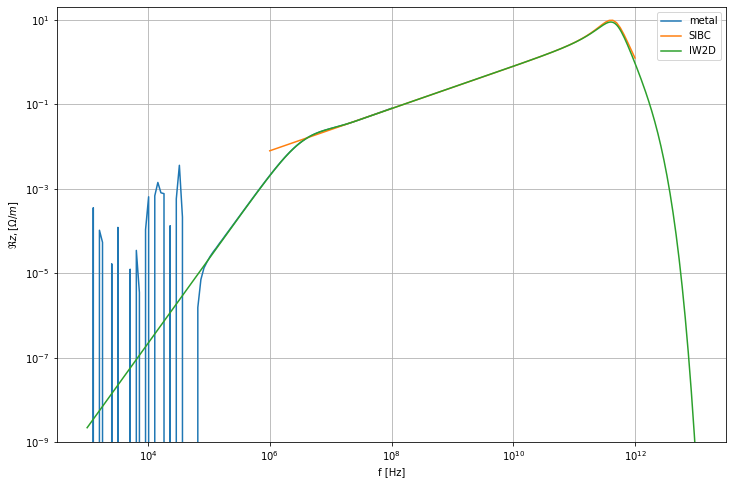

In [10]:
pylab.plot(data_monopole_metal[:,0], data_monopole_metal[:,1])
pylab.plot(data_monopole_sibc[:,0], data_monopole_sibc[:,1])
pylab.plot(iw2d_monopole[:,0], iw2d_monopole[:,1])
pylab.ylim((1e-9, 2e1))
pylab.yscale("log")
pylab.xscale("log")
pylab.xlabel("f [Hz]")
pylab.ylabel(r"$\Re{z}, [\Omega/m]$")
pylab.grid()
pylab.legend(["metal", "SIBC", "IW2D"])
pylab.show()

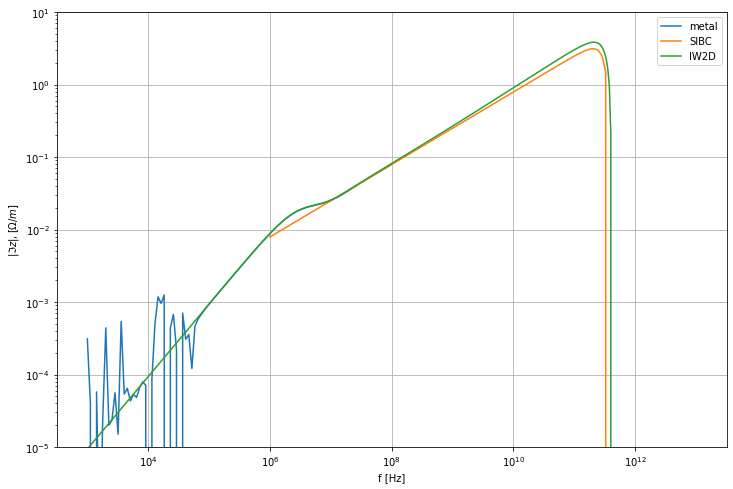

In [11]:
pylab.plot(data_monopole_metal[:,0], data_monopole_metal[:,2])
pylab.plot(data_monopole_sibc[:,0], data_monopole_sibc[:,2])
pylab.plot(iw2d_monopole[:,0], iw2d_monopole[:,2])
pylab.ylim((1e-5, 1e1))
pylab.xscale("log")
pylab.yscale("log")
pylab.xlabel("f [Hz]")
pylab.ylabel(r"$|\Im{z}|, [\Omega/m]$")
pylab.grid()
pylab.legend(["metal", "SIBC", "IW2D"])
pylab.show()

## Calculate dipole impedance

Calculate impedance in frequency range and save the results

In [12]:
%%time

data_dipole_metal = solution_metal.get_z(np.logspace(3, 8, num=100), beta=0.999999, source_function=bi2d.SourceFunction.DIPOLE)

CPU times: user 55min 43s, sys: 1min 44s, total: 57min 27s
Wall time: 57min 28s


In [13]:
%%time

data_dipole_sibc = solution_sibc.get_z(np.logspace(6, 12, num=100), beta=0.999999, source_function=bi2d.SourceFunction.DIPOLE, sibc=[wall])

CPU times: user 25min 20s, sys: 55.7 s, total: 26min 16s
Wall time: 26min 33s


In [14]:
iw2d_dipole = np.genfromtxt("ZxdipWthin_pipe_2layers40.00mm_0_999999beta.dat", skip_header=1)

## Plot dipole impedance

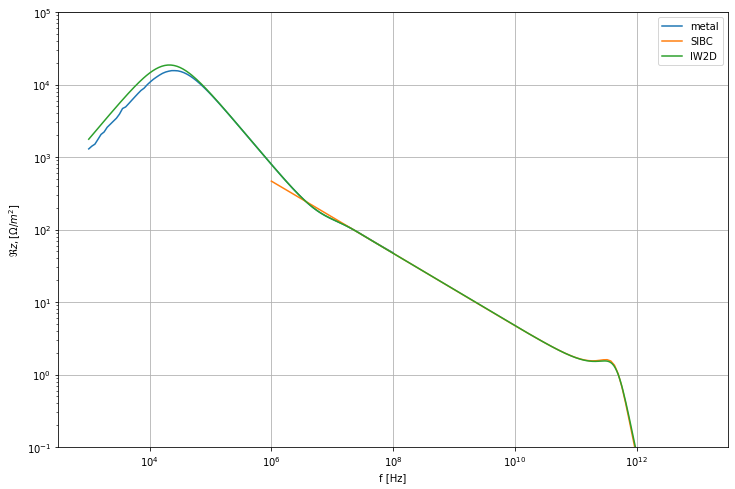

In [15]:
pylab.plot(data_dipole_metal[:,0], data_dipole_metal[:,1])
pylab.plot(data_dipole_sibc[:,0], data_dipole_sibc[:,1])
pylab.plot(iw2d_dipole[:,0], iw2d_dipole[:,1])
pylab.ylim((1e-1, 1e5))
pylab.yscale("log")
pylab.xscale("log")
pylab.xlabel("f [Hz]")
pylab.ylabel(r"$\Re{z}, [\Omega/m^2]$")
pylab.grid()
pylab.legend(["metal", "SIBC", "IW2D"])
pylab.show()

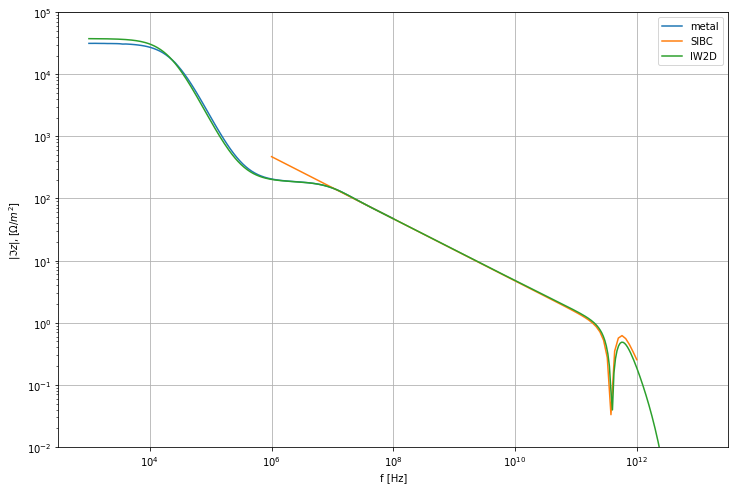

In [16]:
pylab.plot(data_dipole_metal[:,0], data_dipole_metal[:,2])
pylab.plot(data_dipole_sibc[:,0], np.abs(data_dipole_sibc[:,2]))
pylab.plot(iw2d_dipole[:,0], np.abs(iw2d_dipole[:,2]))
pylab.ylim((1e-2, 1e5))
pylab.xscale("log")
pylab.yscale("log")
pylab.xlabel("f [Hz]")
pylab.ylabel(r"$|\Im{z}|, [\Omega/m^2]$")
pylab.grid()
pylab.legend(["metal", "SIBC", "IW2D"])
pylab.show()